# Aufgabe 3: Inverse Filterung
Ist die einem aufgenommenen Bild $g = (f * h) + n$ zugrundeliegende Störfunktion $h$ und deren Fouriertransformierte $H = \mathcal{F}(h)$ bekannt, so kann mittels *inverser Filterung* die Fouriertransformierte des Originalbildes $f$ rekonstruiert werden:
\begin{align}
  \widehat{F}(u, v) &= \frac{G(u,v)}{H(u,v)} \,.
\end{align}
Dabei ist
\begin{align}
  \widehat{F}(u, v) &= F(u,v) + \frac{N(u,v)}{H(u,v)}
\end{align}
weiterhin durch einen unbekannten additiven Rauschprozess $n$ gestört.

Modellieren Sie einen selbstgewählten Störprozess (beispielsweise die durch Bewegung der Kamera während der Bildaufnahme erzeugte Bewegungsunschärfe oder atmosphärische Störungen, siehe Vorlesungsfolien) und simulieren Sie dessen Auswirkungen auf einigen Beispielbildern!

Versuchen Sie nun, mittels inverser Filterung das Originalbild zu rekonstruieren!
Wiederholen Sie diesen Versuch mit verschiedenen den eigentlichen Störprozess begleitenden Rauschprozessen und variieren Sie deren Intensitäten!
Beschreiben und erklären Sie Ihre Beobachtungen!

## 0. Pfade, Pakete etc.

In [89]:
import glob
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np

In [90]:
image_filter = '../Bilder/*.jpg'

## 1. Definition der Störprozesse

Definieren Sie den **Störprozess** als Funktion $H$ der Koordinaten $(u,v)$ im Frequenzbereich.  
Gehen Sie dabei von normalisierten Koordinaten $u, v \in [-1,1]$ aus!

In [91]:
# Bewegungsunschärfe
# Im Frequenzbereich: H(u,v) = sin(pi*a*u + v*b) / (pi*a*u + pi*v*b)
a = 30  # horizontale Bewegung
b = 30  # vertikale Bewegung
H = lambda u, v: np.sinc(a*u + v*b)

Geben Sie nun einen additiven **Rauschprozess** als Funktion $N$ an, die ebenfalls im Frequenzbereich vorliegt.

*Hinweis: Normalverteiltes Rauschen ist im Frequenzbereich ebenfalls normalverteilt (sowohl im reellen als auch imaginären Bestandteil).*

In [92]:
# Normalverteiltes Rauschen im Frequenzbereich (Real- und Imaginärteil)
noise_strength = 5.0  # Rauschintensität
N = lambda u, v: np.complex128(np.random.normal(0, noise_strength) + 1j * np.random.normal(0, noise_strength))

## 2. Laden des Bildes

In [93]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann nicht immer korrekt gerechnet werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [94]:
image = image.astype(np.float32)
image -= image.min()
image /= image.max()

## 3. Simulation der Störung

Wir definieren zunächst eine Hilfsfunktion `ex4_apply_noise`, die ein Originalbild $f$ mit den Prozessen $H$ und $N$ stört und das gestörte Bild $g$ zurückgibt:

In [95]:
def ex4_apply_noise(f, H, N):
    # Fouriertransformation
    F = np.fft.fftshift(np.fft.fft2(f))
    
    G = np.zeros_like(F)
    
    for u, v in np.ndindex(*f.shape):
        u_ = 2 * (float(u) / f.shape[0]) - 1.0
        v_ = 2 * (float(v) / f.shape[1]) - 1.0
        
        # Anwendung des Prozesses N und H
        G[u,v] = F[u,v] * H(u_, v_) + N(u_, v_)
    
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))
    return g

Die Funktion wird nun eingesetzt, um das Bild einmal nur durch $H$ und einmal durch $H$ und $N$ zu stören.

In [96]:
g = ex4_apply_noise(image, H, lambda u, v: 0)  # Störung nur durch H, N ist 0
g_noise = ex4_apply_noise(image, H, N)

Visualisieren Sie `image`, `g` und `g_noise` nebeneinander:

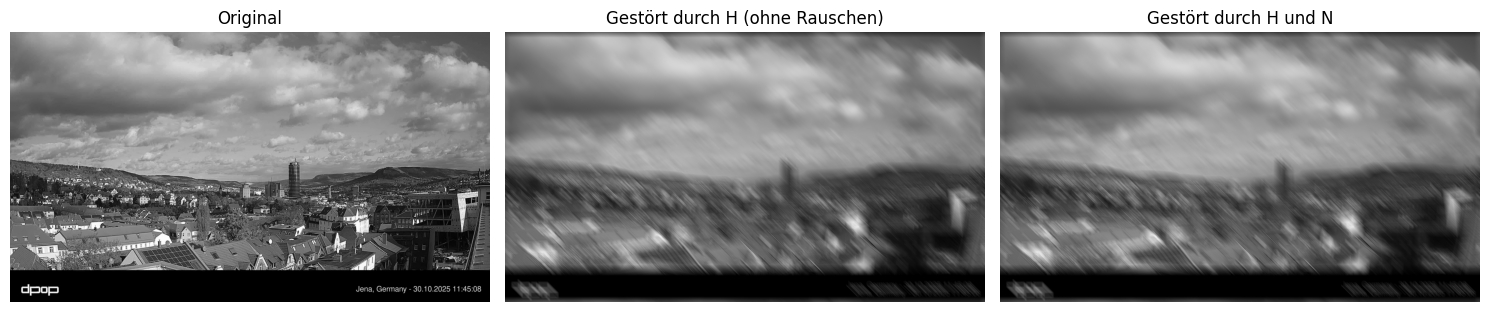

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(g, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Gestört durch H (ohne Rauschen)')
axes[1].axis('off')

axes[2].imshow(g_noise, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Gestört durch H und N')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Wäre leichter abzustreiten, wenn das Bild so aussehen würde wie rechts.

## 4. Rekonstruktion
Es soll nun versucht werden, das Originalbild $f$ aus `g` und `g_noise` mittels inverser Filterung wiederherzustellen. Dazu definieren wir zunächst eine Funktion `ex4_inverse_filter`, die mit Hilfe der Gleichung (1) eine solche durchführt und das entstörte Bild $\hat{f}$ zurückgibt. Dabei ist diesmal allerdings nur $H$ bekannt:

In [98]:
def ex4_inverse_filter(g, H, epsilon=1e-10):
    # Fouriertransformation
    G = np.fft.fftshift(np.fft.fft2(g))
    F_hat = np.zeros_like(G)
    for u, v in np.ndindex(*g.shape):
        u_ = 2 * (float(u) / g.shape[0]) - 1.0
        v_ = 2 * (float(v) / g.shape[1]) - 1.0

        H_uv = H(u_, v_)
        # Robuste Division: Vermeidung von Division durch sehr kleine Werte
        if np.abs(H_uv) > epsilon:
            F_hat[u,v] = G[u,v] / H_uv
        else:
            F_hat[u,v] = 0.0  # Setze auf Null, wenn H zu klein ist

    f_ = np.real(np.fft.ifft2(np.fft.ifftshift(F_hat)))
    return f_

Die Funktion wird jetzt für `g1` und `g2` aufgerufen:

In [99]:
recons = ex4_inverse_filter(g, H)
recons_noise = ex4_inverse_filter(g_noise, H)

Visualisieren Sie nun das Originalbild `image` neben den Rekonstruktionen `recons` und `recons_noise`:

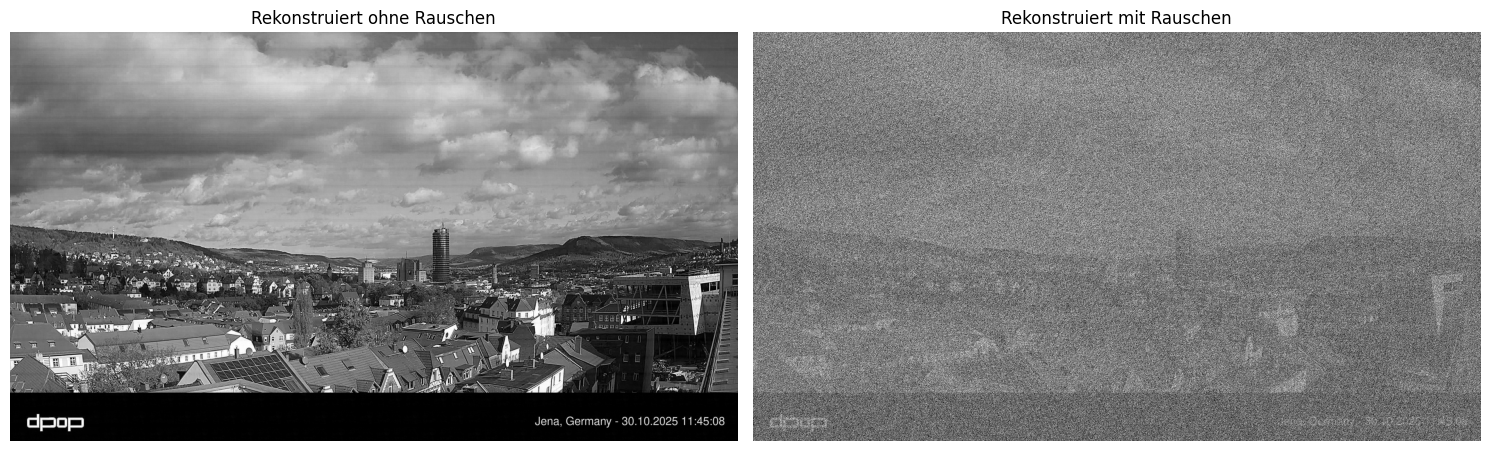

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(recons, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Rekonstruiert ohne Rauschen')
axes[0].axis('off')

axes[1].imshow(recons_noise, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Rekonstruiert mit Rauschen')
axes[1].axis('off')

plt.tight_layout()
plt.show()
